In [1]:
import torch

In [3]:
import os
from PIL import Image
from torchvision import transforms
from torchvision.datasets import DatasetFolder
import cv2
import numpy as np


def load_image(img_path:str):    
        np_img = cv2.imread(img_path) #CV2 to open and convert BMP mages into NUMPY    
        #np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        return Image.fromarray(np_img)  #we need Image for the transforms to work correctly

dset = DatasetFolder(root='RowanDLclassNEA/NEUdata', loader = load_image, extensions = ('.bmp',))


In [4]:
img_path = 'RowanDLclassNEA/NEUdata/Cr/Cr_10.bmp'
np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
np_img = cv2.imread(img_path)

In [5]:
np_img_gray.shape

(200, 200)

In [6]:
np_img.shape

(200, 200, 3)

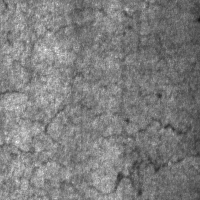

In [7]:
dset[10][0]

In [8]:
len(dset)

1800

In [9]:
data, label = dset[0]
print(type(data))

<class 'PIL.Image.Image'>


In [10]:
print(data)

<PIL.Image.Image image mode=RGB size=200x200 at 0x1B5F1D0CAF0>


#### We need to write a transform to make it compatible with AlexNet (size 224x224x3, and type tensor)

In [11]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])

dset = DatasetFolder(root='RowanDLclassNEA/NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)

### Note that load_image  needed to return a PIL.Image for the transforms to be correctly applied


In [12]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      dset, 
                      [1200, 600])

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16, 
                    shuffle=True)

print(len(trainloader))
# out: 2500
print(len(valloader))
# out: 625

75
38


## In what units is the length of the loaders?

In [13]:
dd,ll = next(iter(trainloader))

 ### We are going to illustrate transfer learning now
Transfer starts with a pretrained model from the torchvision library. The pretrained model will be resnet18. This model is trained on ImageNet 1K (this is the default for resnet18: DEFAULT = IMAGENET1K_V1)
The fact that ImageNet consists of RGB images of size 224 x 224 demanded our data resizing in the transform

In [14]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

model = models.resnet18()
#summary(model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### notice that the last layer of the resnet18 is a linear layer with output size 1000
Let's get rid of it, because we have only 6 classes!

Plus, add the FlattenLayer to see what is the linearized size of the last AvgPool

In [17]:
layers = list(model.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())   
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 512]                 --
+ Conv2d: 1-1                            [16, 64, 112, 112]        9,408
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          128
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          128
|    |    + ReLU: 3-6                    [16, 64, 56, 56]          --
|

In [18]:
layers.append(nn.Linear(512,6))
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 6]                   --
+ Conv2d: 1-1                            [16, 64, 112, 112]        9,408
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          128
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          128
|    |    + ReLU: 3-6                    [16, 64, 56, 56]          --
|

### Alternatively, just replace model.fc with the linear layer

In [19]:
alt_model = model
alt_model.fc = nn.Linear(512,6)

In [20]:
from torch import optim
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vec_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 1.1432726494471233 Val Loss: 0.9164359036244845
Epoch: 1 Train Loss: 0.689293641646703 Val Loss: 1.9271922127196663
Epoch: 2 Train Loss: 0.5476816936333975 Val Loss: 0.647187382767075
Epoch: 3 Train Loss: 0.5136606977383296 Val Loss: 0.6753145001436535
Epoch: 4 Train Loss: 0.4271737742424011 Val Loss: 0.447147922492341
Epoch: 5 Train Loss: 0.39247906357049944 Val Loss: 0.5264858556421179
Epoch: 6 Train Loss: 0.35792495891451837 Val Loss: 0.2737916594273166
Epoch: 7 Train Loss: 0.2855372872451941 Val Loss: 1.3987606928536767
Epoch: 8 Train Loss: 0.31796951964497566 Val Loss: 0.6810315916143161
Epoch: 9 Train Loss: 0.2750146352251371 Val Loss: 0.37610240810011564
Epoch: 10 Train Loss: 0.22510099860529104 Val Loss: 0.17837533031247163
Epoch: 11 Train Loss: 0.1919638752688964 Val Loss: 0.3275534755697376
Epoch: 12 Train Loss: 0.21421533140043417 Val Loss: 0.948225202529054
Epoch: 13 Train Loss: 0.19168099249402681 Val Loss: 0.14263821505990468
Epoch: 14 Train Loss: 0.1

Text(0.5, 1.0, 'Loss Curves')

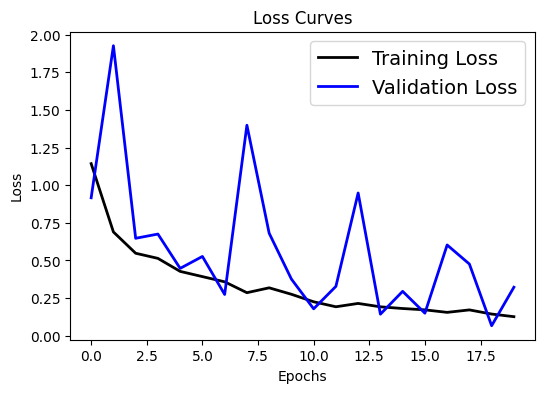

In [21]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)